# Implementation of a simple denoising diffusion probabilistic model (DDPM) for MNIST using PyTorch


**Bachelor thesis - June 2024** 

_Gregory Sedykh_

## Introduction

This Jupyter notebook aims to provide a real example of a Denoising Diffusion Probabilistic Model (DDPM) for generating images of numbers trained on the MNIST dataset.

## Initialisation

This notebook requires: numpy, matplotlib and PyTorch

We start by installing and importing the necessary modules.

In [1]:
%%capture
%pip install torch torchvision
%pip install numpy
%pip install matplotlib

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

import time

The device on which the model will be trained and run on is then chosen: CUDA for Nvidia GPUs, MPS (Metal Performance Shaders) for Macs with M chips or if these aren't available, CPU by default.

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


## U-Net

The neural network used by Ho et al. in their DDPM paper is a U-Net.

Although the U-Net implementation here is not the same as the one the authors used, nor the one from the original U-Net paper from Ronneberger et al., they are the same in terms of structure.

They essentially contain:
- an encoder or a contracting path
- a bottleneck
- a decoder or an expanding path

The U-Net takes an $n \times n$ size image as input and outputs an image of the same size.

The input is an image from the MNIST dataset with added noise $\epsilon$ to it. The noise $\epsilon \sim \mathcal{N}(0, I_{n \times n})$ is also given as input to the U-Net.

### Time embedding

In order for the model to know the time step of the image it wil attempt to denoise, time embedding is required.

For this, they used a sinusoidal embedding from the Transformer paper by Vaswani et al.

$$ PE_{(pos, 2i)} = \sin \left( \frac{pos}{10000^{2i/d_{model}}} \right) $$
$$ PE_{(pos, 2i+1)} = \cos \left( \frac{pos}{10000^{2i/d_{model}}} \right)$$ 
where $pos$ is the position and $i$ is the dimension

The `time_embedding` function takes in the total number of `timesteps` and the time dimension `time_dim` and returns the sinusoidal embedding as a tensor.

In [4]:
def time_embedding(timesteps: torch.Tensor, time_dim: int) -> torch.Tensor:
    """
    Sinusoidal time embeddings
    Args:
        timesteps: tensor of shape (batch_size,) - time steps
        time_dim: int - dimension of the time embedding
    Returns:
        tensor of shape (batch_size, time_dim) - time embeddings
    """
    denom = torch.arange(1, time_dim // 2 + 1, dtype=torch.float32)
    sin = torch.sin(timesteps[:, None] / 10000 ** (2 * (denom - 1) / time_dim))
    cos = torch.cos(timesteps[:, None] / 10000 ** (2 * (denom - 1) / time_dim))
    emb = torch.cat([sin, cos], dim=-1)

    return emb

### Residual Block

The DDPM paper used convolutional residual blocks based on the ResNet architecture.

They contain:
- a convolutional layer
- an activation function
- another convolutional layer
- a normalisation layer
- an activation function

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_dim, dropout=0.1):
        super().__init__()

        self.time_embed = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_dim, out_channels)
        )

        self.dropout = nn.Dropout(dropout)

        self.gn1 = nn.GroupNorm(8, in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)

        self.gn2 = nn.GroupNorm(8, out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)

        if in_channels != out_channels:
            self.residual = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.residual = nn.Identity()


    def forward(self, x, t):
        out = x

        out = self.gn1(out)
        out = F.silu(out)
        out = self.conv1(out)

        out = out + self.time_embed(t)[:, :, None, None]

        out = self.gn2(out)
        out = F.silu(out)
        out = self.dropout(out)
        out = self.conv2(out)

        out = out + self.residual(x)

        return out

### Downsampling and Upsampling

The encoder and decoder contain downsampling and upsampling blocks respectively.

In [6]:
class DownsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        Upsamples from in_channels to out_channels

        Args:
            in_channels: int - number of input channels
            out_channels: int - number of output channels
        """
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)

    def forward(self, x, t):
        return self.conv(x)

In [7]:
class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        Downsamples from in_channels to out_channels

        Args:
            in_channels: int - number of input channels
            out_channels: int - number of output channels
        """
        super().__init__()
        self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)

    def forward(self, x, t):
        return self.conv(x)

### Combination of modules to create the U-Net

Using the above modules, we can now create the U-Net.

The U-Net contains:
- a time embedding MLP
- a first convolutional layer to go from the number of channels (1: grayscale, 3: RGB) to the number of channels in the first residual block
- an encoder with 4 residual blocks, each except the last one followed by a downsampling block
- a bottleneck with 2 residual blocks (if self-attention were to be used, it would go between the two)
- a decoder with 4 residual blocks, each except the last one followed by an upsampling block
- a final normalisation layer, activation function and convolutional layer to back to the original number of channels
- skip connections where the downsampled images in the encoder are concatenated with the upsampled images in the decoder

In [8]:
class UNet(nn.Module):
    def __init__(self, img_channels):
        super().__init__()

        self.time_dim = 128

        self.time_proj = nn.Sequential(
            nn.Linear(self.time_dim, self.time_dim),
            nn.SiLU(),
            nn.Linear(self.time_dim, self.time_dim)
        )

        self.img_channels = img_channels

        self.first_conv = nn.Conv2d(self.img_channels, 32, kernel_size=3, stride=1, padding=1)

        self.encoder = nn.ModuleList()

        self.encoder.append(ResidualBlock(32, 32, self.time_dim))
        self.encoder.append(DownsampleBlock(32, 64))
        self.encoder.append(ResidualBlock(64, 64, self.time_dim))
        self.encoder.append(DownsampleBlock(64, 128))
        self.encoder.append(ResidualBlock(128, 128, self.time_dim))
        self.encoder.append(DownsampleBlock(128, 256))
        self.encoder.append(ResidualBlock(256, 256, self.time_dim))


        self.bottleneck = nn.ModuleList()
        self.bottleneck.append(ResidualBlock(256, 256, self.time_dim))
        self.bottleneck.append(ResidualBlock(256, 256, self.time_dim))

        self.decoder = nn.ModuleList()
        self.decoder.append(ResidualBlock(256, 256, self.time_dim))
        self.decoder.append(UpsampleBlock(256, 128))
        self.decoder.append(ResidualBlock(256, 128, self.time_dim))
        self.decoder.append(UpsampleBlock(128, 64))
        self.decoder.append(ResidualBlock(128, 64, self.time_dim))
        self.decoder.append(UpsampleBlock(64, 32))
        self.decoder.append(ResidualBlock(64, 32, self.time_dim))

        self.final_norm = nn.GroupNorm(8, 32)
        self.final_activation = nn.SiLU()
        self.final_conv = nn.Conv2d(32, self.img_channels, kernel_size=3, padding=1)


    def forward(self, x, t):

        out = self.first_conv(x)

        time_emb = time_embedding(t, self.time_dim).to(x.device)
        time_emb = self.time_proj(time_emb)


        skips = []
        for layer in self.encoder:
            if isinstance(layer, DownsampleBlock):
                skips.append(out)
            out = layer(out, time_emb)


        for layer in self.bottleneck:
            out = layer(out, time_emb)


        for layer in self.decoder:
            if isinstance(layer, UpsampleBlock):
                out = layer(out, time_emb)
                out = torch.cat([out, skips.pop()], dim=1)
            else:
                out = layer(out, time_emb)

        out = self.final_norm(out)
        out = self.final_activation(out)
        out = self.final_conv(out)

        return out


## Diffusion Model

With the U-Net in place, we can now define the entire diffusion model.

The diffusion model has a forward process, a loss function and a sampling process.

In [9]:
class DiffusionModel:
    def __init__(self, timesteps: torch.Tensor, model, device):
        """
        Args:
            timesteps: torch.Tensor - tensor of shape (timesteps,) containing the number of timesteps
            model: nn.Module - model to be used for the diffusion process
            device: torch.device - device to be used
        """

        self.device = device
        self.model = model.to(self.device)
        self.timesteps = timesteps

        # Forward process parameters
        # A linear schedule is used for beta as in the DDPM paper but this can be changed for another schedule (e.g. cosine)
        self.beta_linear_schedule = torch.linspace(10**(-4), 0.02, timesteps.shape[0]).to(self.device)
        self.alpha_schedule = 1 - self.beta_linear_schedule
        self.alpha_prod = torch.cumprod(self.alpha_schedule, dim=0)

        self.sigma2 = self.beta_linear_schedule


    def forward_process(self, x_0, t, noise=None):
        """
        Input:
            x_0: tensor of shape (batch_size, 3, H, W) - image to be noised
            t: int - timestep
        Output:
            x_t: tensor of shape (batch_size, 3, H, W) - noised image for the given timestep t
        """
        mean = torch.sqrt(self.alpha_prod[t]) * x_0
        std = torch.sqrt(1 - self.alpha_prod[t])
        
        if noise is None:
            noise = torch.randn_like(x_0) * std
        x_t = mean + noise * std

        return x_t


    def loss(self, x_0, t, eps):
        """
        Input:
            x_0: tensor of shape (batch_size, 3, H, W) - image
            t: tensor of shape (batch_size,) - timestep
            eps: tensor of shape (batch_size, 3, H, W) - noise
        Output:
            returns the MSE loss for the given timestep t
        """
        # Given an image x_0, a timestep t and noise eps, we compute the noised image x_t
        x_t = self.forward_process(x_0, t, eps)

        # The model is trained to predict the noise eps added to the image x_t to find x_{t-1}
        # The loss is defined as the MSE between the predicted noise and the true noise
        loss = F.mse_loss(self.model(x_t, t), eps)

        return loss


    def sample(self, nb: int):
        """
        Samples a random image from the model.
        Based on Algorithm 2 from the DDPM paper.
        """
        self.model.eval()
        with torch.no_grad():
            # x_t ~ N(0, I)
            x_t = torch.randn(nb, 1, 32, 32).to(self.device)

            # for t = T, T-1, ..., 1 do
            for t in reversed(range(self.timesteps.shape[0])):
                if t > 1:
                    # if t > 1, sample z ~ N(0, I)
                    z = torch.randn_like(x_t)
                else:
                    # else z = 0
                    z = torch.zeros_like(x_t)

                # Compute scaling factors and noise contributions
                sqrt_alpha_t_inv = 1 / torch.sqrt(self.alpha_schedule)
                sqrt_one_minus_alpha_prod_t = torch.sqrt(1 - self.alpha_prod)
                sqrt_beta_t = torch.sqrt(self.sigma2)

                # Predict noise using the model
                predicted_noise = self.model(x_t, torch.tensor([t-1]))

                # Denoise step (compute x_{t-1} from x_t)
                x_t = sqrt_alpha_t_inv[t-1] * (x_t - (1 - self.alpha_schedule[t-1])/(sqrt_one_minus_alpha_prod_t[t-1]) * predicted_noise) + sqrt_beta_t[t-1] * z

            return x_t

## Training

### Dataset

Having chosen the MNIST dataset, we apply a little bit of preprocessing to it in order to make it compatible with the U-Net.

We first need the images to be converted to tensors so that they can be fed into the U-Net.

The images are then resized from $28 \times 28$ to $32 \times 32$ for simplification (avoids having to deal with odd dimensions when downsampling).

Finally, the images are normalised to be between -1 and 1 as required by the neural network.

We can then load (or download) the MNIST dataset, apply the transformations and then create a DataLoader with a batch size of 64 for training.

In [10]:
# Definition of transformations for the dataset
transform = transforms.Compose([
    
    # Convert the image to a tensor
    transforms.ToTensor(),

    # Resize the image to 32x32 (from 28x28)
    transforms.Resize((32, 32)),

    # Normalize the image to the range [-1, 1] used by the U-Net
    transforms.Normalize((0.5,), (0.5,)),
])

# Load the MNIST dataset with the defined transformations
dataset = datasets.MNIST(root="data", download=True, transform=transform)

# Create a DataLoader for the dataset
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

### Setup

To setup the training, we need to define the model and the hyperparameters.

In [11]:
# Timesteps tensor
timesteps = torch.Tensor(1000).to(device)

# U-Net for 32x32 images, with 1 input channel (grayscale, for RGB images use 3 channels)
unet = UNet(img_channels=1)
print("U-Net parameters: ", sum(p.numel() for p in unet.parameters() if p.requires_grad))

ddpm = DiffusionModel(timesteps, unet, device)

U-Net parameters:  7339297


The learning rate is set to $10^{-4}$ since by testing different values, this one was found to be good.

The number of epochs is set to 40 as this should be sufficient for the model to train, although even 20 epochs are enough to get recognisable images.

The optimizer used is Adam.

In [12]:
learning_rate = 1e-4
epochs = 40
optimizer = torch.optim.Adam(unet.parameters(), lr=learning_rate)

### Training loop

The training loop is based on Algorithm 1 from the DDPM paper.

For each epoch:
- sample a batch of images from the dataset (until all images have been used)
- choose a random timestep $t$ from $[0, T]$
- sample noise $\epsilon \sim \mathcal{N}(0, I_{n \times n})$
- calculate the loss between the noised images at timestep $t$ and the U-Net's attempt to obtain the images at timestep $t$ after trying to remove the noise $\epsilon$
- take a step in the direction of the gradient of the loss

After all the batches have been processed, we print the average loss and the time taken for the epoch

In [13]:
def train(diffusion_model, data_loader, optimizer, epochs):
    diffusion_model.model.train()

    for epoch in range(epochs):
        start_time = time.time()
        total_loss = 0
        count = 0

        for images, _ in data_loader:

            # x_0 ~ q(x_0)
            images = images.to(device)

            # t ~ Uniform(1, T)
            t = torch.randint(1, diffusion_model.timesteps.shape[0], (1,))

            # eps ~ N(0, I)
            eps = torch.randn_like(images)

            # Take gradient descent step
            loss = diffusion_model.loss(images, t, eps)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            count += 1


        average_loss = total_loss / count
        end_time = time.time()
        print(f'Epoch {epoch+1}/{epochs}, Average Loss: {average_loss:.4f}, Time: {end_time - start_time:.2f}s')

    # Save the model state as a .pth file so it can be loaded later
    torch.save(diffusion_model.model.state_dict(), "unet_model_state.pth")

In [ ]:
# Train the model by running the training loop for the specified number of epochs
train(ddpm, data_loader, optimizer, epochs=epochs)

## Forward Process

After training the model, we can first look at the forward process.

Let's start by loading a batch of images from the MNIST dataset to see what kind of images we will be working with.

In [14]:
def tensor_to_images(tensor):
    images = tensor.permute(1, 2, 0).detach().cpu().numpy()
    images = images / 2 + 0.5
    return images

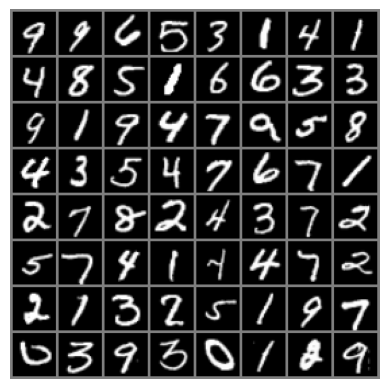

In [15]:
features, labels = next(iter(data_loader))
img = torchvision.utils.make_grid(features)

img = tensor_to_images(img)

plt.axis('off')
plt.imshow(img)
plt.show()

`show_forward_process` shows the steps of the noising done by the forward process.

In [16]:
def show_forward_process(x_0, steps: list):

    # Create a figure with subplots
    fig, ax = plt.subplots(1, len(steps) + 1, figsize=(15, 5))

    # Show the original image
    ax[0].imshow(tensor_to_images(x_0[0]), cmap="gray")
    ax[0].axis("off")
    ax[0].set_title("Original")

    # Show the forward process
    for i, step in enumerate(steps):
        x_0 = x_0.to(device)
        x_t = ddpm.forward_process(x_0, step-1)
        ax[i + 1].imshow(tensor_to_images(x_t[0]), cmap="gray")
        ax[i + 1].axis("off")
        ax[i + 1].set_title(f"Step {step}")

Let's take a random image from the dataset and see how the image is gradually noised until timestep $T$, where it becomes nearly completely Gaussian noise.

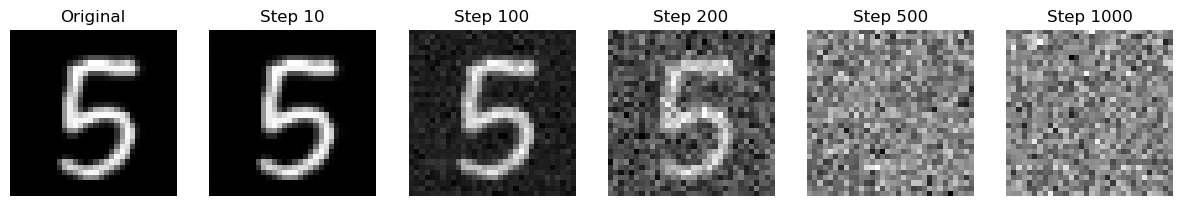

In [47]:
# Pick a random image from the dataset
img = (dataset[np.random.randint(0, len(dataset))][0]).unsqueeze(0)

# Show the forward process
show_forward_process(img, [10, 100, 200, 500, 1000])

## Sampling

### Loading the model

If we have a trained model, we can load it here.

In [18]:
state_dict = torch.load("unet_model_state.pth", map_location=device)
unet.load_state_dict(state_dict)

<All keys matched successfully>

### Sampled images

Using the `sample` function of the `DiffusionModel` class which is based on Algorithm 2 of the DDPM paper, we can sample a batch of images from the model.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


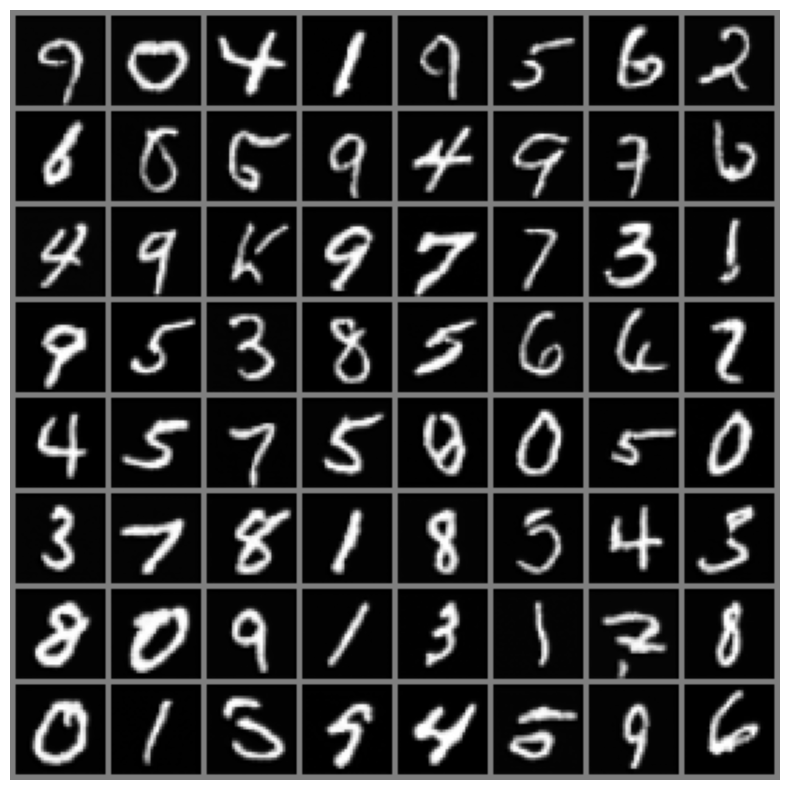

In [19]:
# Show batch of denoised images
generated_images = ddpm.sample(64)
denoised_images = tensor_to_images(torchvision.utils.make_grid(generated_images))

plt.figure(figsize=(10, 10))
plt.imshow(denoised_images, cmap='gray')
plt.axis('off')
plt.show()


## Conclusion

In this notebook, we have:
- implemented and trained a U-Net used for predicting added noise to images from the MNIST dataset
- defined the forward process of the diffusion model and displayed the destruction of an image over the time steps
- sampled images from the trained diffusion model to generate new, never before seen images of numbers similar to those in the MNIST dataset